pip install xgboost


In [1]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# === Load and clean data ===
data = pd.read_csv("merged_train_with_features.csv")

target_cols = [
    'voltage_rise_time_pulse1', 'voltage_rise_time_pulse2',
    'voltage_fall_time_pulse1', 'voltage_fall_time_pulse2',
    'current_rise_time_pulse1', 'current_rise_time_pulse2',
    'current_fall_time_pulse1', 'current_fall_time_pulse2',
    'overshoot_pulse_1', 'overshoot_pulse_2',
    'undershoot_pulse_1', 'undershoot_pulse_2',
    'ringing_frequency_MHz'
]



In [3]:
scale_targets = ['voltage_rise_time_pulse1', 'current_rise_time_pulse2', 'current_fall_time_pulse2']
scaling_factor = 1e9

# Drop rows with NaN in targets
data_clean = data.dropna(subset=target_cols)
X = data_clean.drop(columns=["DeviceID"] + target_cols)
y = data_clean[target_cols].copy()

# Scale the selected targets
for col in scale_targets:
    y[col] *= scaling_factor

# Fill missing values in features
X = X.fillna(X.mean(numeric_only=True))

# === Feature Scaling ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y.values, test_size=0.2, random_state=42
)



📊 XGBoost Performance with Target Scaling:
                      Target  R2 Score      RMSE       MAE
0   voltage_rise_time_pulse1    0.0557  0.000000  0.000000
1   voltage_rise_time_pulse2    0.9934  0.000002  0.000001
2   voltage_fall_time_pulse1    0.9539  0.000002  0.000001
3   voltage_fall_time_pulse2    0.9563  0.000002  0.000001
4   current_rise_time_pulse1    0.9726  0.000002  0.000001
5   current_rise_time_pulse2    0.9382  0.000000  0.000000
6   current_fall_time_pulse1    0.4811  0.000008  0.000002
7   current_fall_time_pulse2    0.4597  0.000000  0.000000
8          overshoot_pulse_1    0.9984  1.082986  0.760046
9          overshoot_pulse_2    1.0000  1.682222  0.899679
10        undershoot_pulse_1    0.9810  3.333209  1.914430
11        undershoot_pulse_2    0.9530  7.905131  2.572677
12     ringing_frequency_MHz    0.9994  1.317664  0.922681


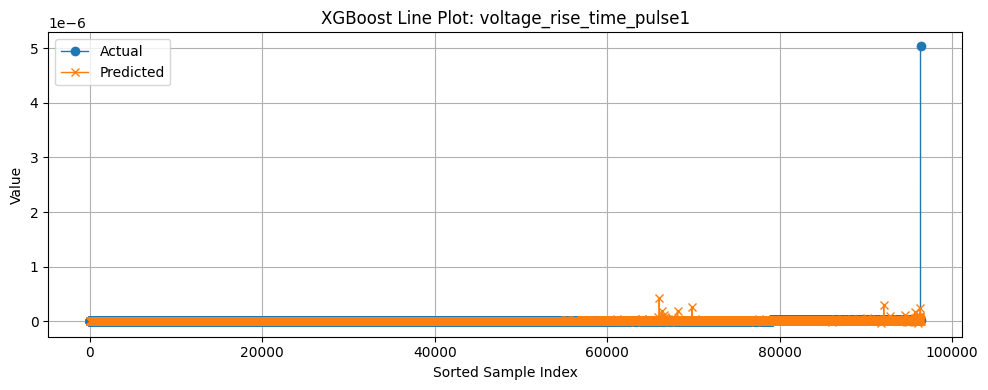

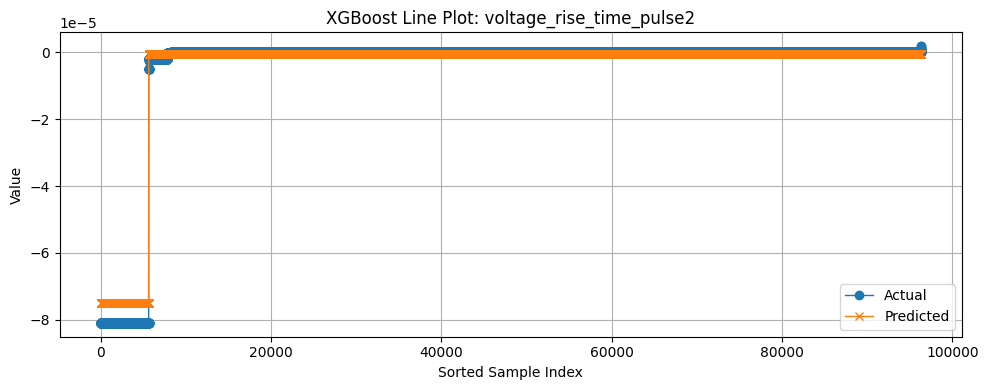

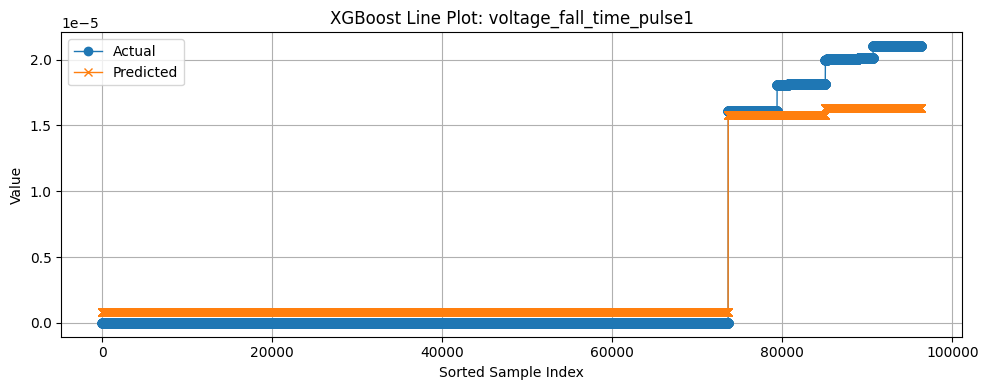

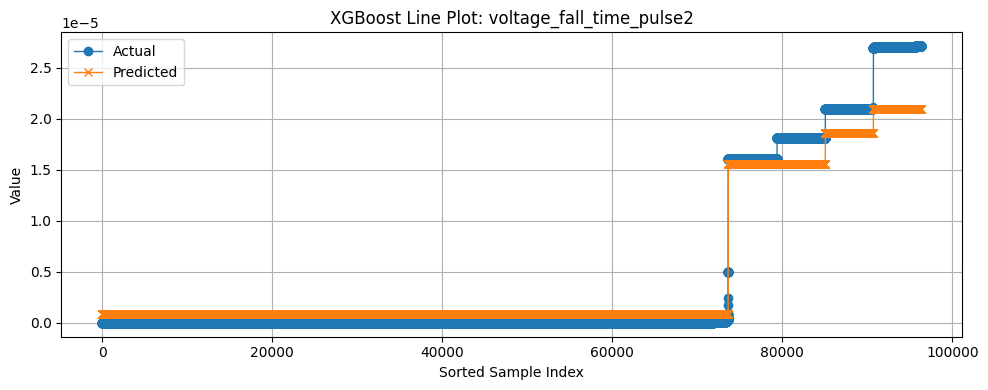

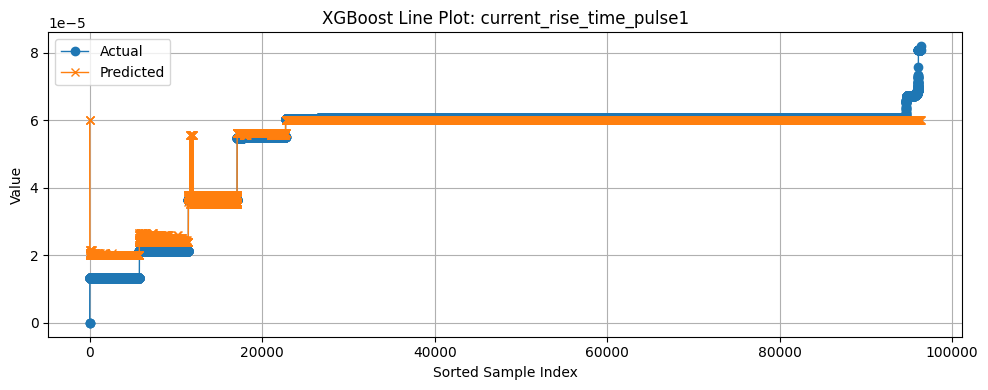

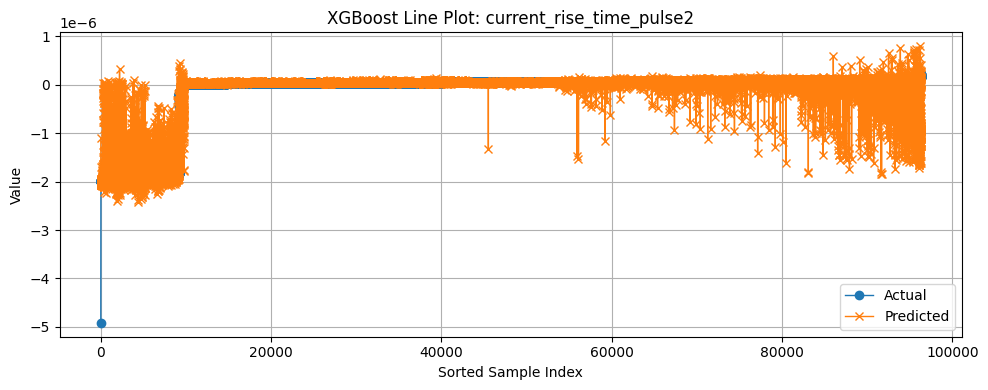

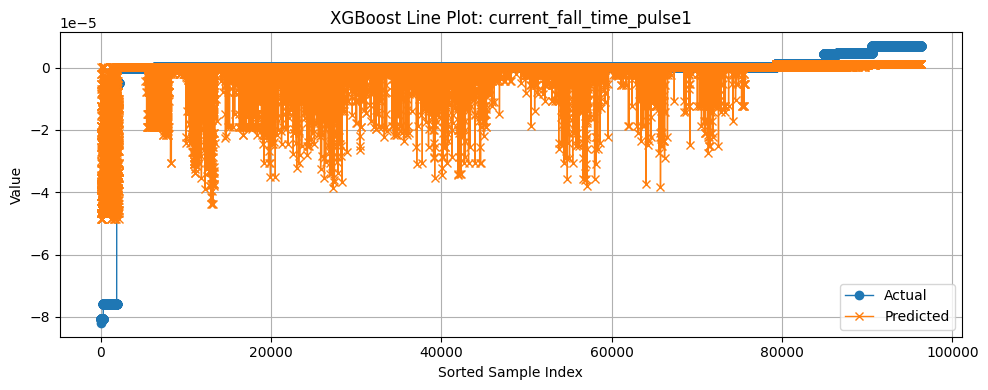

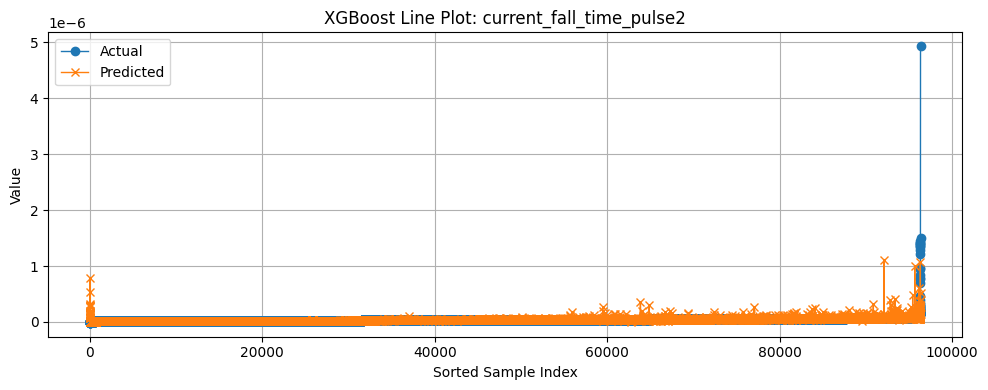

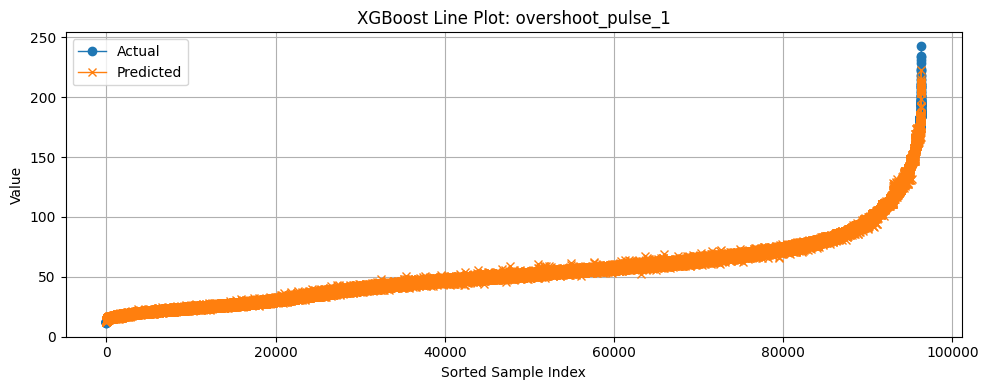

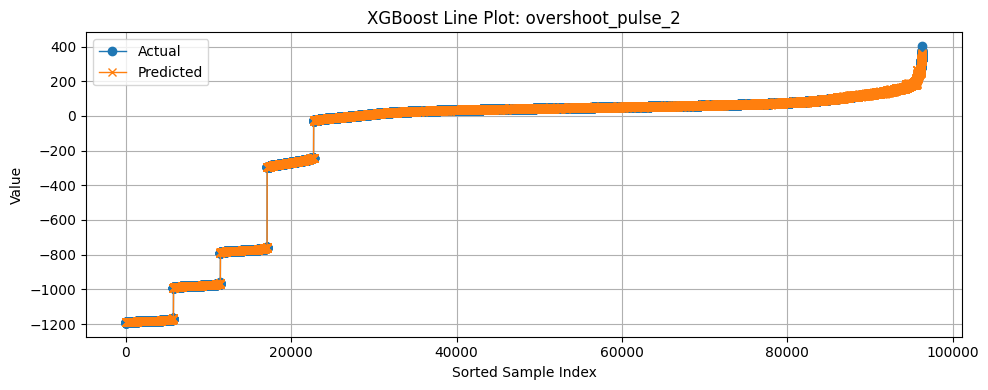

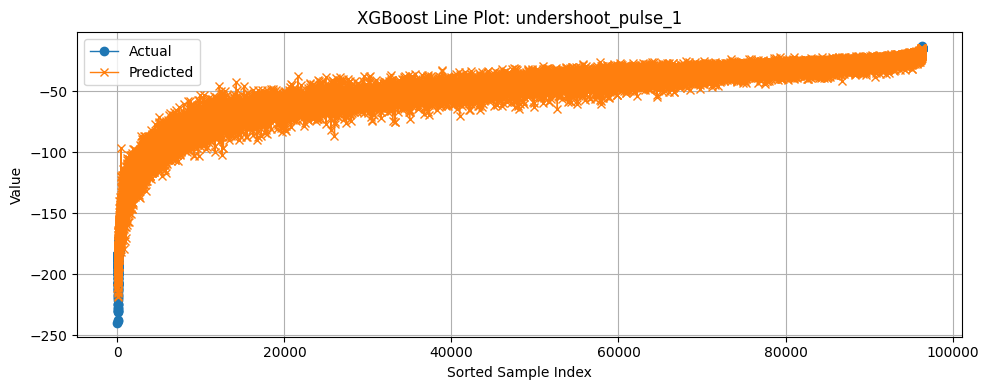

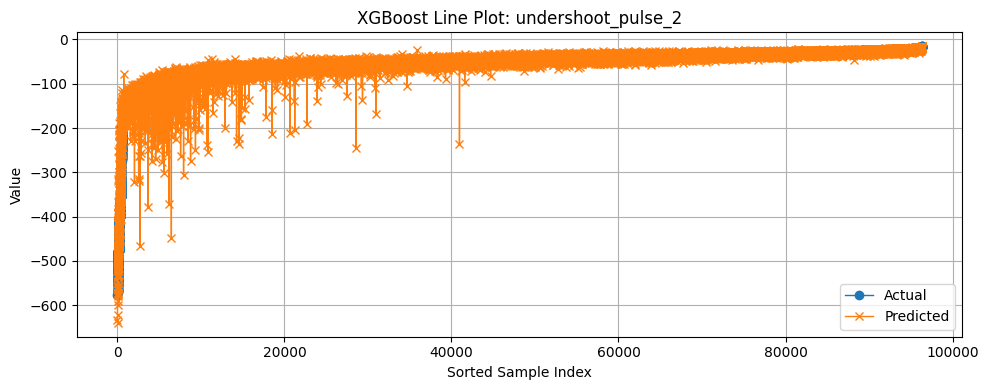

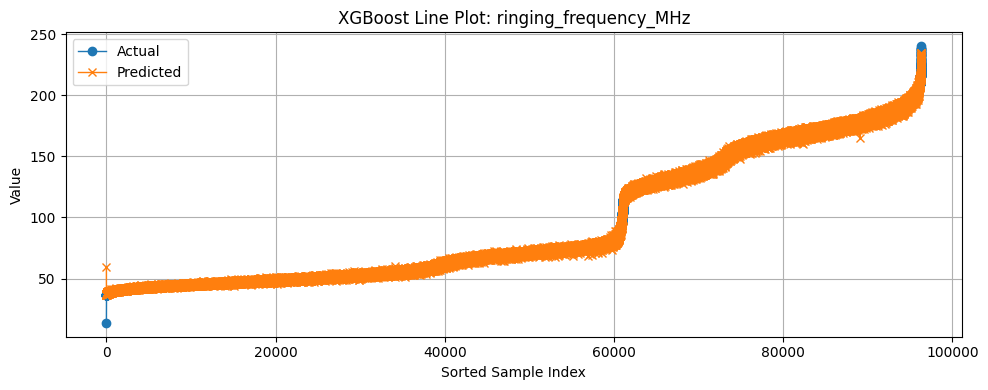

In [8]:

# === Train XGBoost per target ===
y_preds = []
results = []

for i, target in enumerate(target_cols):
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, n_jobs=-1)
    model.fit(X_train, y_train[:, i])
    y_pred = model.predict(X_test)

    # Unscale prediction if needed
    if target in scale_targets:
        y_pred /= scaling_factor
        y_test_unscaled = y_test[:, i] / scaling_factor
    else:
        y_test_unscaled = y_test[:, i]

    y_preds.append(y_pred)

    r2 = r2_score(y_test_unscaled, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
    mae = mean_absolute_error(y_test_unscaled, y_pred)

    results.append({
        "Target": target,
        "R2 Score": round(r2, 4),
        "RMSE": round(rmse, 6),
        "MAE": round(mae, 6)
    })

# === Show performance table ===
performance_df = pd.DataFrame(results)
print("\n📊 XGBoost Performance with Target Scaling:")
print(performance_df)

# === Plot Line Charts: Actual vs Predicted ===
y_preds_matrix = np.vstack(y_preds).T  # shape: (n_samples, 13)

for i, target in enumerate(target_cols):
    # Prepare actuals
    if target in scale_targets:
        actual = y_test[:, i] / scaling_factor
    else:
        actual = y_test[:, i]
    predicted = y_preds_matrix[:, i]

    # Sort by actual for smoother plot
    sorted_idx = np.argsort(actual)
    actual_sorted = actual[sorted_idx]
    predicted_sorted = predicted[sorted_idx]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(actual_sorted, label='Actual', marker='o', linewidth=1)
    plt.plot(predicted_sorted, label='Predicted', marker='x', linewidth=1)
    plt.title(f"XGBoost Line Plot: {target}")
    plt.xlabel("Sorted Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [5]:
# === Load new test data ===
test_data = pd.read_csv("merged_test_with_features.csv")

# Separate actual values (if any exist) for comparison
y_actual_test = {}
for col in target_cols:
    if col in test_data.columns:
        y_actual_test[col] = test_data[col].copy()

# Drop DeviceID and any target columns (if present)
X_new = test_data.drop(columns=["DeviceID"] + [col for col in target_cols if col in test_data.columns], errors="ignore")

# Fill missing values and apply the same scaling
X_new = X_new.fillna(X_new.mean(numeric_only=True))
X_new_scaled = scaler.transform(X_new)

# === Predict using trained models ===
test_predictions = {}

for i, target in enumerate(target_cols):
    # Predict using the already trained model
    y_pred = y_preds[i]  # Reuse prediction if needed — OR:
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, n_jobs=-1)
    model.fit(X_train, y_train[:, i])  # You must save models during training to skip this line
    y_pred = model.predict(X_new_scaled)

    # Unscale if needed
    if target in scale_targets:
        y_pred /= scaling_factor
        if target in y_actual_test:
            y_actual_test[target] /= scaling_factor

    test_predictions[target + "_predicted"] = y_pred

# === Save predictions to CSV ===
results_df = pd.DataFrame(test_predictions)

# Optionally add actuals if available
for col in y_actual_test:
    results_df[col + "_actual"] = y_actual_test[col].values

# Save to CSV
results_df.to_csv("actual_vs_predicted_test_data.csv", index=False)
print("\n✅ Saved predictions to 'actual_vs_predicted_test_data.csv'")



✅ Saved predictions to 'actual_vs_predicted_test_data.csv'


In [6]:
y[['voltage_rise_time_pulse1', 'current_fall_time_pulse1', 'current_fall_time_pulse2']].std()

voltage_rise_time_pulse1    11.260144
current_fall_time_pulse1     0.000011
current_fall_time_pulse2    27.928916
dtype: float64

Target: voltage_rise_time_pulse1
R² Score: 0.6172
RMSE: 0.000000
MAE: 0.000000


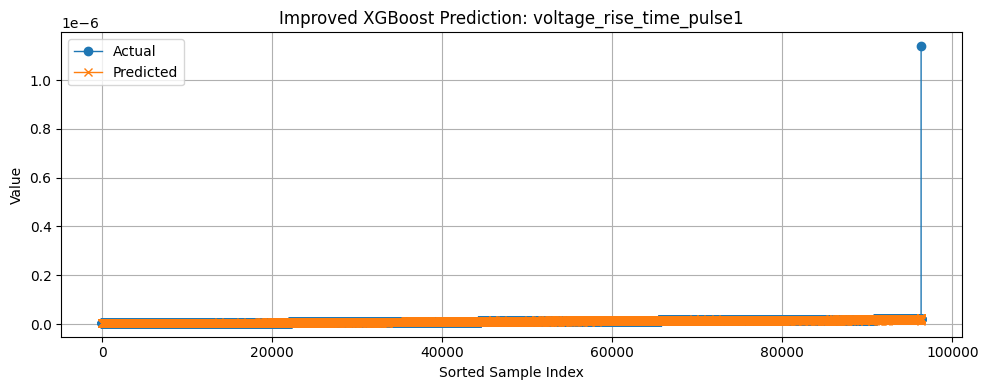

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# === Step 1: Load and clean data ===
data = pd.read_csv("merged_train_with_features.csv")

target = "voltage_rise_time_pulse1"

# Drop rows with NaN in target
data_clean = data.dropna(subset=[target])

# === Step 2: Feature-target separation ===
X = data_clean.drop(columns=["DeviceID", target])
y = data_clean[target]

# === Step 3: Feature engineering (optional but helpful) ===
if 'Vbus' in X.columns and 'L_total' in X.columns:
    X["Vbus_Ls"] = X["Vbus"] * X["L_total"]
if 'Qgd' in X.columns and 'Coss' in X.columns:
    X["Qgd_over_Coss"] = X["Qgd"] / (X["Coss"] + 1e-9)

# === Step 4: Impute and scale features ===
X = X.fillna(X.mean(numeric_only=True))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Step 5: Transform the target for better modeling ===
pt = PowerTransformer()
y_transformed = pt.fit_transform(y.values.reshape(-1, 1)).flatten()

# === Step 6: Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_transformed, test_size=0.2, random_state=42)

# === Step 7: Train XGBoost model ===
model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# === Step 8: Make predictions and inverse transform ===
y_pred_transformed = model.predict(X_test)
y_pred = pt.inverse_transform(y_pred_transformed.reshape(-1, 1)).flatten()
y_actual = pt.inverse_transform(y_test.reshape(-1, 1)).flatten()

# === Step 9: Evaluate performance ===
r2 = r2_score(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)

print(f"Target: {target}")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")

# === Step 10: Plot Actual vs Predicted ===
sorted_idx = np.argsort(y_actual)
plt.figure(figsize=(10, 4))
plt.plot(np.array(y_actual)[sorted_idx], label="Actual", marker="o", linewidth=1)
plt.plot(np.array(y_pred)[sorted_idx], label="Predicted", marker="x", linewidth=1)
plt.title(f"Improved XGBoost Prediction: {target}")
plt.xlabel("Sorted Sample Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
%pip install xlsxwriter

  Using cached xlsxwriter-3.2.5-py3-none-any.whl.metadata (2.7 kB)
Using cached xlsxwriter-3.2.5-py3-none-any.whl (172 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# === Step 11: Save actual vs predicted to Excel ===
results_df = pd.DataFrame({
    "Actual": y_actual,
    "Predicted": y_pred
})

# Save to Excel with the target name as sheet
with pd.ExcelWriter("actual_vs_predicted_outputs.xlsx", engine="xlsxwriter") as writer:
    results_df.to_excel(writer, sheet_name=target[:31], index=False)
